# Imports

In [1]:
import scikeras

In [2]:
import pandas as pd
import numpy as np
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
import joblib
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
# import plotly.offline as pyo

import plotly.io as pio
pio.renderers.default='notebook'

import matplotlib.pyplot as plt
# pyo.init_notebook_mode()

from time import time

In [3]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

# Cargar datasets

In [4]:
X_train = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos_exogena/X_train_2y.csv', parse_dates=[0], index_col='datetime_utc')
y_train = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos_exogena/y_train_2y.csv', parse_dates=[0], index_col='datetime_utc')
X_test = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos_exogena/X_test.csv', parse_dates=[0], index_col='datetime_utc')
y_test = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos_exogena/y_test.csv', parse_dates=[0], index_col='datetime_utc')
test_data = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos_exogena/test_data.csv', parse_dates=[0], index_col='datetime_utc')

# Reordenar el input para ajustarlo a los nuevos canales de la convolucional

In [5]:
percentage_columns = [col for col in X_train.columns if 'percentage' in col]
wind_columns = [col for col in X_train.columns if 'wind' in col]
new_column_order = percentage_columns + wind_columns

In [6]:
new_column_order

['percentage(t-11)',
 'percentage(t-10)',
 'percentage(t-9)',
 'percentage(t-8)',
 'percentage(t-7)',
 'percentage(t-6)',
 'percentage(t-5)',
 'percentage(t-4)',
 'percentage(t-3)',
 'percentage(t-2)',
 'percentage(t-1)',
 'percentage(t)',
 'wind_100(t-11)',
 'wind_100(t-10)',
 'wind_100(t-9)',
 'wind_100(t-8)',
 'wind_100(t-7)',
 'wind_100(t-6)',
 'wind_100(t-5)',
 'wind_100(t-4)',
 'wind_100(t-3)',
 'wind_100(t-2)',
 'wind_100(t-1)',
 'wind_100(t)',
 'wind_100(t+1)',
 'wind_100(t+2)',
 'wind_100(t+3)',
 'wind_100(t+4)',
 'wind_100(t+5)',
 'wind_100(t+6)']

In [7]:
X_train = X_train[new_column_order]
X_test = X_test[new_column_order]

# 4. CNN keras

In [8]:
start = time()
def get_CNN(n_conv_layers, hidden_layer_sizes, alpha, n_filters, kernel_size):
    target_shape = (6, 5) # reshape a (6, 5)
    input_shape=(30,)
    model = keras.Sequential()
    model.add(keras.layers.Reshape(target_shape, input_shape=input_shape))
    
    for i in range(n_conv_layers):
        model.add(keras.layers.Conv1D(input_shape=target_shape, filters=n_filters, kernel_size=kernel_size,
                                      padding='causal', activation='relu', kernel_regularizer=keras.regularizers.L2(alpha)))
        model.add(keras.layers.AveragePooling1D(pool_size=2, strides=1))
        target_shape=(input_shape[0]-kernel_size+1, n_filters)
        
    model.add(keras.layers.Flatten())
    
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation="relu", kernel_regularizer=keras.regularizers.L2(alpha),)
        model.add(layer)
    out = keras.layers.Dense(6, kernel_regularizer=keras.regularizers.L2(alpha),)
    model.add(out)
    return model

cnn = KerasRegressor(
    model=get_CNN,
    loss="mean_absolute_error",
    optimizer='adam',
    epochs=12000,
    verbose=0,
    shuffle=False,
    batch_size=-1,
)

cnn_pipeline = Pipeline(steps=[('std_sc', StandardScaler()),
                               ('cnn', cnn)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=cnn_pipeline,
                                             transformer=y_transformer)

param_grid_CNN = {'regressor__cnn__model__n_conv_layers': [1, 2],
                  'regressor__cnn__model__n_filters': [4, 6],
                  'regressor__cnn__model__alpha': [0.0001, 0.001, 0.01],
#                   'regressor__cnn__model__hidden_layer_sizes': [(60,60), (120,120),],
                  'regressor__cnn__model__hidden_layer_sizes': [(10,10), (30,30),],
                  'regressor__cnn__model__kernel_size': [2, 3],
                 }

# TimeSeries Cross validation
tscv = TimeSeriesSplit(n_splits=2)

# Create the GridSearchCV object
grid_search_CNN = GridSearchCV(inner_estimator, param_grid_CNN, cv=tscv, scoring='neg_mean_absolute_error',
                              n_jobs = -1)

# Fit the GridSearchCV object to the training data
grid_search_CNN.fit(X_train, y_train)

training_time = time() - start
print(training_time/60, ' minutos')

71.67490255832672  minutos


### Training

In [9]:
best_CNN_score = grid_search_CNN.best_score_
best_CNN_model = grid_search_CNN.best_estimator_

In [10]:
best_CNN_model.regressor_.named_steps['cnn'].model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 6, 5)              0         
                                                                 
 conv1d (Conv1D)             (None, 6, 4)              64        
                                                                 
 average_pooling1d (AverageP  (None, 5, 4)             0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                        

In [11]:
grid_search_CNN.best_params_

{'regressor__cnn__model__alpha': 0.0001,
 'regressor__cnn__model__hidden_layer_sizes': (10, 10),
 'regressor__cnn__model__kernel_size': 3,
 'regressor__cnn__model__n_conv_layers': 1,
 'regressor__cnn__model__n_filters': 4}

In [12]:
best_CNN_model

TransformedTargetRegressor(regressor=Pipeline(steps=[('std_sc',
                                                      StandardScaler()),
                                                     ('cnn',
                                                      KerasRegressor(batch_size=-1, epochs=12000, loss='mean_absolute_error', model=<function get_CNN at 0x0000020DC18DF310>, model__alpha=0.0001, model__hidden_layer_sizes=(10, 10), model__kernel_size=3, model__n_conv_layers=1, model__n_filters=4, optimizer='adam', shuffle=False, verbose=0))]),
                           transformer=StandardScaler())

In [13]:
# best_MLP_model.regressor_.named_steps['mlp'].history_

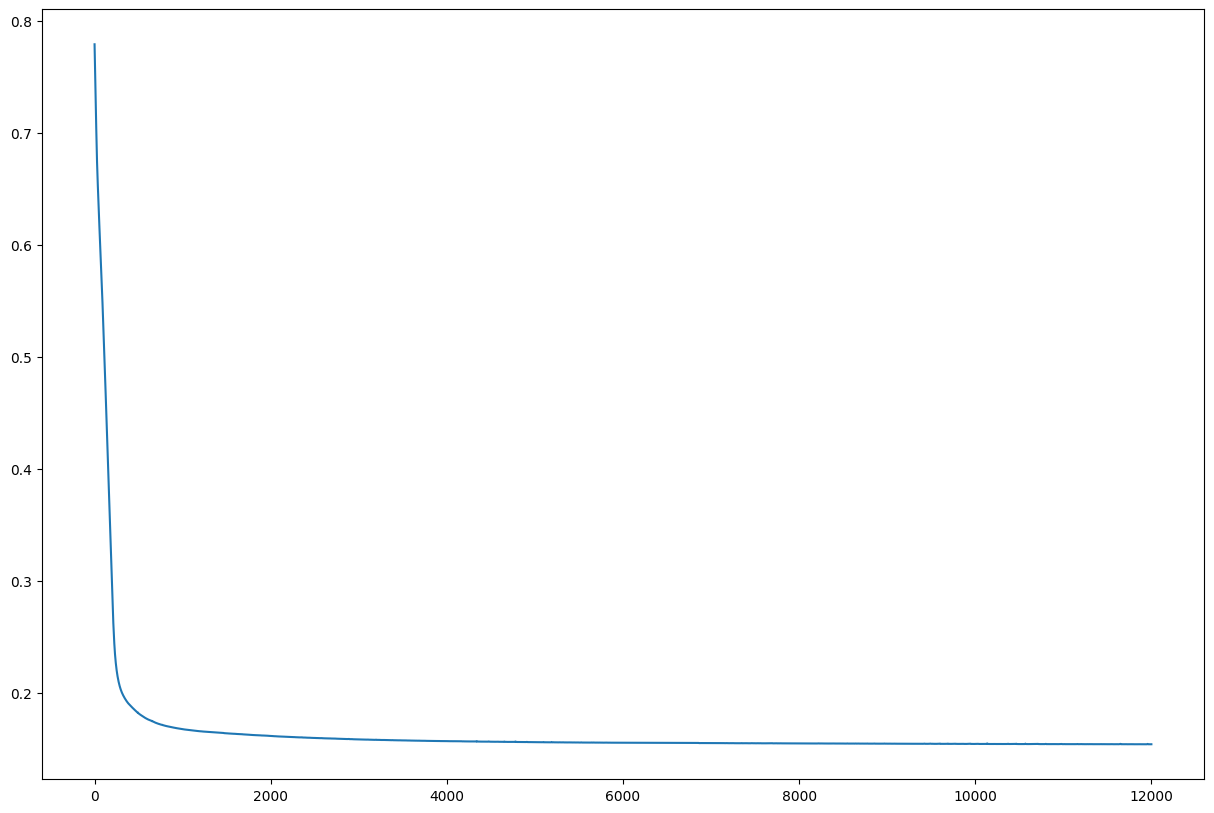

In [14]:
plt.figure(figsize=(15,10))
plt.plot(best_CNN_model.regressor_.named_steps['cnn'].history_['loss'])
# dir(best_MLP_model.regressor_.named_steps['mlp'].history_.values)

### Forecasting

In [15]:
y_pred_CNN = best_CNN_model.predict(X_test)

In [16]:
df_y_pred_CNN = pd.DataFrame(y_pred_CNN, columns=['t+1', 't+2', 't+3', 't+4', 't+5', 't+6'])
df_y_pred_CNN

,t+1,t+2,t+3,t+4,t+5,t+6
0,0.144266,0.137142,0.131379,0.127733,0.125491,0.124969
1,0.142709,0.136954,0.132672,0.130709,0.129991,0.130952
2,0.144003,0.140637,0.138508,0.138720,0.139777,0.142155
3,0.180560,0.183626,0.186106,0.190052,0.193247,0.196842
4,0.181767,0.185391,0.188483,0.192975,0.196640,0.200614
...,...,...,...,...,...,...
8737,0.220296,0.221509,0.222213,0.222981,0.222840,0.223122
8738,0.220759,0.223896,0.226376,0.229045,0.230497,0.232094
8739,0.232352,0.236913,0.239693,0.241956,0.242371,0.242668
8740,0.315054,0.321239,0.321710,0.319717,0.314319,0.308082


In [17]:
MAE_CNN_t1=metrics.mean_absolute_error(y_test['percentage(t+1)'], df_y_pred_CNN['t+1'])
MAE_CNN_t2=metrics.mean_absolute_error(y_test['percentage(t+2)'], df_y_pred_CNN['t+2'])
MAE_CNN_t3=metrics.mean_absolute_error(y_test['percentage(t+3)'], df_y_pred_CNN['t+3'])
MAE_CNN_t4=metrics.mean_absolute_error(y_test['percentage(t+4)'], df_y_pred_CNN['t+4'])
MAE_CNN_t5=metrics.mean_absolute_error(y_test['percentage(t+5)'], df_y_pred_CNN['t+5'])
MAE_CNN_t6=metrics.mean_absolute_error(y_test['percentage(t+6)'], df_y_pred_CNN['t+6'])

In [18]:
print('MAE en t+1: {:2.2%}'.format(MAE_CNN_t1))
print('MAE en t+2: {:2.2%}'.format(MAE_CNN_t2))
print('MAE en t+3: {:2.2%}'.format(MAE_CNN_t3))
print('MAE en t+4: {:2.2%}'.format(MAE_CNN_t4))
print('MAE en t+5: {:2.2%}'.format(MAE_CNN_t5))
print('MAE en t+6: {:2.2%}'.format(MAE_CNN_t6))

MAE en t+1: 0.80%
MAE en t+2: 1.49%
MAE en t+3: 2.07%
MAE en t+4: 2.55%
MAE en t+5: 2.94%
MAE en t+6: 3.26%


# Guardar el modelo

In [25]:
# best_MLP_model.regressor_.named_steps['mlp'].model_.save('modelos/MLP_scikeras_model.h5')
joblib.dump(best_CNN_model, "CNN_all_samples/CNN_model.joblib")

INFO:tensorflow:Assets written to: C:\Users\vmore\AppData\Local\Temp\tmpk0s00v2i\assets


INFO:tensorflow:Assets written to: C:\Users\vmore\AppData\Local\Temp\tmpk0s00v2i\assets


['CNN_all_samples/CNN_model.joblib']

# Cargar el modelo

In [26]:
# loaded_MLP = keras.models.load_model('modelos/MLP_scikeras_model.h5')
loaded_MLP = joblib.load("CNN_all_samples/CNN_model.joblib")

In [21]:
# plt.figure(figsize=(15,10))
# plt.plot(loaded_MLP.regressor_.named_steps['cnn'].history_['loss'][9000:])

In [27]:
y_pred_MLP_loaded = loaded_MLP.predict(X_test)

In [28]:
y_pred_MLP_loaded

array([[0.14426607, 0.13714187, 0.13137947, 0.12773278, 0.12549093,
        0.12496904],
       [0.14270948, 0.1369537 , 0.13267198, 0.13070893, 0.12999076,
        0.1309516 ],
       [0.14400299, 0.14063716, 0.13850771, 0.13872041, 0.13977669,
        0.14215499],
       ...,
       [0.23235154, 0.23691274, 0.23969325, 0.24195585, 0.24237125,
        0.24266842],
       [0.31505406, 0.32123885, 0.32170987, 0.31971687, 0.31431895,
        0.3080825 ],
       [0.3026242 , 0.30573386, 0.30384576, 0.29978782, 0.29292458,
        0.28576934]], dtype=float32)

In [30]:
# loaded_MLP.summary()